## Setup

In [23]:
import pandas as pd
import tensorflow as tf
from keras import callbacks, optimizers, Sequential
from keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [39]:
print(tf.sysconfig.get_build_info())
print(f'tensorflow version {tf.__version__}')
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_logical_devices('GPU'))

OrderedDict([('cpu_compiler', '/usr/lib/llvm-18/bin/clang'), ('cuda_compute_capabilities', ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90']), ('cuda_version', '12.5.1'), ('cudnn_version', '9'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False)])
tensorflow version 2.18.0
Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [4]:
# df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
df = pd.read_csv('bikes.csv')
df.head() 

,dteday,hr,casual,registered,temp_c,feels_like_c,hum,windspeed,weathersit,season,holiday,workingday
0,1/1/2011,0.0,3,13,3.0,3.0,0.7957,0.8,1,1,0,0
1,1/1/2011,1.0,8,30,1.7,1.7,0.8272,0.8,1,1,0,0
2,1/1/2011,2.0,5,26,1.9,1.9,0.8157,1.1,1,1,0,0
3,1/1/2011,3.0,3,9,2.5,2.5,0.7831,0.8,1,1,0,0
4,1/1/2011,4.0,0,1,2.0,2.0,0.8075,1.1,1,1,0,0


## Data Transformation

In [6]:
def split_date(df: pd.DataFrame) -> pd.DataFrame:  
    # Extract year, month, and day into separate columns and convert to numbers (rather than strings)
    df[['month', 'day', 'year']] = df['dteday'].str.extract(r'(\d*)/(\d*)/(\d*)')
    df['month'] = pd.to_numeric(df['month'])
    df['day'] = pd.to_numeric(df['day'])
    df['year'] = pd.to_numeric(df['year'])
    # Don't need the garbage format date column, throw it away
    df.drop(columns=['dteday'], errors='ignore', inplace=True)
    return df

# df = split_date(df)
# df.head(220) # confirm that one- and two-digit months and days are handled correctly
# df.info()

In [7]:
def convert_categorical(df: pd.DataFrame) -> pd.DataFrame:
    # One-hot encode the categorical variables
    df['weathersit'] = df['weathersit'].map({1: 'none', 2: 'light', 3: 'moderate', 4: 'heavy'})
    df['season'] = df['season'].map({1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'})
    df = pd.get_dummies(df, columns=['season', 'weathersit'], prefix=['','weather'], prefix_sep=['','_'], dtype=int)
    return df

# df = convert_categorical(df)
# df.head()

In [9]:
df = pd.read_csv('bikes.csv')
df = split_date(df)
df = convert_categorical(df)
# df.info()
df.head()

,hr,casual,registered,temp_c,feels_like_c,hum,windspeed,holiday,workingday,month,day,year,fall,spring,summer,winter,weather_heavy,weather_light,weather_moderate,weather_none
0,0.0,3,13,3.0,3.0,0.7957,0.8,0,0,1,1,2011,0,0,0,1,0,0,0,1
1,1.0,8,30,1.7,1.7,0.8272,0.8,0,0,1,1,2011,0,0,0,1,0,0,0,1
2,2.0,5,26,1.9,1.9,0.8157,1.1,0,0,1,1,2011,0,0,0,1,0,0,0,1
3,3.0,3,9,2.5,2.5,0.7831,0.8,0,0,1,1,2011,0,0,0,1,0,0,0,1
4,4.0,0,1,2.0,2.0,0.8075,1.1,0,0,1,1,2011,0,0,0,1,0,0,0,1


## Daylight Savings Exploration

As I was exploring the data, I found out that the hour of 2 a.m. has 13 less entries than all of the other ones, which was weird to me. Upon further examination, the "missing" 2 a.m. entry occurred in March of each year, which led me to believe it might be because of Daylight Savings. Turns out, that's entirely correct: March 13, 2011 was Daylight Savings, and that day is missing an entry for 2 a.m.

This does, however, raise the question of why there isn't a *duplicate* 2 a.m. entry each November...

In [ ]:
df['hr'].value_counts() # 2 a.m. has 13 less entries than the other hours

In [ ]:
# max_year = df['year'].max()
# min_year = df['year'].min()
# max_month = df[df['year'] == max_year]['month'].max()
# min_month = df[df['year'] == min_year]['month'].min()
# num_months = (max_year - min_year) * 12 + max_month - min_month + 1

one_day_per_month = df[(df['day'] == 1) & (df['hr'] == 0.0)][['month', 'year']].copy()
num_months = one_day_per_month.shape[0]
num_years = one_day_per_month['year'].nunique()
od = one_day_per_month
num_29 = od[(od['month'] != 2) | ((od['month'] == 2) & (od['year'] % 4 == 0))].shape[0]
num_30 = od[(od['month'] != 2)].shape[0]
num_31 = od[(od['month'] != 2) & (od['month'] != 4) & (od['month'] != 6) & (od['month'] != 9) & (od['month'] != 11)].shape[0]

print(f'{num_months} total months in the dataset.') # 154
print(f'{num_29} have at least 29 days.') # 144
print(f'{num_30} have at least 30 days.') # 141
print(f'{num_31} have 31 days.') # 90

In [ ]:
just_1am = df[df['hr'] == 1]
# just_1am['day'].value_counts()
# This has the expected number of entries.
just_1am_filtered = just_1am[(just_1am['day'] == 8) | (just_1am['day'] == 9) | (just_1am['day'] == 10) | (just_1am['day'] == 11) | (just_1am['day'] == 12) | (just_1am['day'] == 13) | (just_1am['day'] == 14)]
just_1am_filtered = just_1am_filtered[(just_1am_filtered['month'] == 3)]
just_1am_filtered['day'].value_counts()

In [ ]:
just_2am = df[df['hr'] == 2]
# just_2am['day'].value_counts()
just_2am_filtered = just_2am[(just_2am['day'] == 8) | (just_2am['day'] == 9) | (just_2am['day'] == 10) | (just_2am['day'] == 11) | (just_2am['day'] == 12) | (just_2am['day'] == 13) | (just_2am['day'] == 14)]
just_2am_filtered = just_2am_filtered[(just_2am_filtered['month'] == 3)]
just_2am_filtered['day'].value_counts()
# just_2am_filtered[['month', 'day', 'year']].to_csv('just_2am_filtered.csv', index=False)

In [ ]:
dmy_2am = just_2am[(just_2am['day'] == 8) | (just_2am['day'] == 9) | (just_2am['day'] == 10) | (just_2am['day'] == 11) | (just_2am['day'] == 12) | (just_2am['day'] == 13) | (just_2am['day'] == 14)]
dmy_2am = dmy_2am[(dmy_2am['month'] == 3)]
dmy_2am = dmy_2am[['day', 'year']]
# dmy_2am.head()

daylight_savings_days = {}
for year in range(df['year'].min(), df['year'].max() + 1):
    for day in range(8, 15):
        if day not in dmy_2am[dmy_2am['year'] == year].to_numpy():
            daylight_savings_days[year] = day

for year, day in daylight_savings_days.items():
    print(f'{year}: March {day}')

# These are all correct.

## Model Generation

In [8]:
bikes = pd.read_csv('bikes.csv')
bikes = split_date(bikes)
bikes = convert_categorical(bikes)
# bikes.info()
bikes.head()

,hr,casual,registered,temp_c,feels_like_c,hum,windspeed,holiday,workingday,month,day,year,fall,spring,summer,winter,weather_heavy,weather_light,weather_moderate,weather_none
0,0.0,3,13,3.0,3.0,0.7957,0.8,0,0,1,1,2011,0,0,0,1,0,0,0,1
1,1.0,8,30,1.7,1.7,0.8272,0.8,0,0,1,1,2011,0,0,0,1,0,0,0,1
2,2.0,5,26,1.9,1.9,0.8157,1.1,0,0,1,1,2011,0,0,0,1,0,0,0,1
3,3.0,3,9,2.5,2.5,0.7831,0.8,0,0,1,1,2011,0,0,0,1,0,0,0,1
4,4.0,0,1,2.0,2.0,0.8075,1.1,0,0,1,1,2011,0,0,0,1,0,0,0,1


In [9]:
X = bikes.drop(columns=['casual', 'registered'])
y = bikes[['casual', 'registered']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# print(X_train.shape)

In [11]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2))

I0000 00:00:1740207759.421498    1330 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [12]:
opt = optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_percentage_error'])

In [19]:
early_stop = callbacks.EarlyStopping(patience=30)

history = model.fit(X_train, y_train, epochs=2000, validation_split=.35, batch_size=2048, callbacks=[early_stop], shuffle=False)
# history = model.fit(train_features, train_labels, epochs=2000, verbose=0, validation_split = .2, batch_size=tester2,
#                     callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)

Epoch 1/2000


2025-02-22 00:06:32.173732: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1079', 48 bytes spill stores, 48 bytes spill loads

2025-02-22 00:06:32.396577: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1079', 3092 bytes spill stores, 3076 bytes spill loads

2025-02-22 00:06:32.429293: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1079', 4628 bytes spill stores, 4640 bytes spill loads



24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17697.0039 - mean_absolute_percentage_error: 603431488.0000

2025-02-22 00:06:33.993408: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1079', 876 bytes spill stores, 876 bytes spill loads



25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 17706.4453 - mean_absolute_percentage_error: 600986496.0000 - val_loss: 13068.3691 - val_mean_absolute_percentage_error: 506717536.0000
Epoch 2/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17848.2891 - mean_absolute_percentage_error: 602528576.0000 - val_loss: 13094.2783 - val_mean_absolute_percentage_error: 502538784.0000
Epoch 3/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17408.6621 - mean_absolute_percentage_error: 584051968.0000 - val_loss: 13054.7900 - val_mean_absolute_percentage_error: 501515168.0000
Epoch 4/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17658.2500 - mean_absolute_percentage_error: 575683456.0000 - val_loss: 13040.0869 - val_mean_absolute_percentage_error: 503297760.0000
Epoch 5/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17469.3203 - mean_absolute_percentage_error: 591683520.0000 - val_loss: 12980.7354 - val_mean_absolute_percentage_error: 505545152.0000
Epoch 6/2000
25/25 ━━━━━━━━━━━━

## Post-Generation Exploration

In [20]:
hist

,loss,mean_absolute_percentage_error,val_loss,val_mean_absolute_percentage_error
0,17819.744141,571646272.0,13068.369141,506717536.0
1,17926.939453,573132800.0,13094.278320,502538784.0
2,17566.271484,569306944.0,13054.790039,501515168.0
3,17839.525391,563969920.0,13040.086914,503297760.0
4,17680.894531,573214656.0,12980.735352,505545152.0
...,...,...,...,...
436,15569.055664,653919232.0,10482.656250,601590592.0
437,15688.673828,669727232.0,10413.814453,601552768.0
438,15501.209961,660570688.0,10535.070312,598220352.0
439,15379.966797,654020096.0,10361.249023,600115328.0


In [21]:
hist = hist.reset_index()

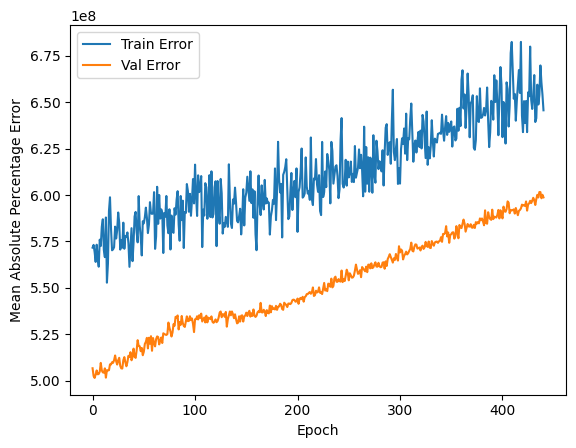

In [26]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Percentage Error')
    plt.plot(hist['index'], hist['mean_absolute_percentage_error'], label='Train Error')
    plt.plot(hist['index'], hist['val_mean_absolute_percentage_error'], label = 'Val Error')
    plt.legend()
    # plt.ylim([0,50])

plot_history()

## Mini Holdout

In [27]:
mini = pd.read_csv('bikes_holdout_mini.csv')
mini = split_date(mini)
mini = convert_categorical(mini)
# mini.info()
mini.head()

,hr,temp_c,feels_like_c,hum,windspeed,holiday,workingday,month,day,year,fall,weather_light,weather_moderate,weather_none
0,0.0,7.3,7.3,0.6667,0.0,0,1,11,15,2023,1,0,0,1
1,1.0,6.2,6.2,0.7406,0.0,0,1,11,15,2023,1,0,0,1
2,2.0,5.2,3.2,0.8232,8.5,0,1,11,15,2023,1,0,0,1
3,3.0,5.7,3.6,0.7573,9.4,0,1,11,15,2023,1,1,0,0
4,4.0,5.2,2.9,0.7918,10.1,0,1,11,15,2023,1,1,0,0


In [28]:
mini = mini.reindex(columns = X.columns, fill_value=0)
mini_X = scaler.transform(mini)

In [35]:
predictions = model.predict(mini_X)
pred_df = pd.DataFrame(predictions, columns=['casual', 'registered'])
pred_df.to_csv('predictions_dual.csv', index=False)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [38]:
pred_df_merged = pd.DataFrame({'predictions': pred_df['casual'] + pred_df['registered']})
pred_df_merged.to_csv('team5-module4-predictions.csv', index=False)